In [1]:
from dataclasses import dataclass
import numpy as np
import mediapy as media
from pathlib import Path
import enum
from tqdm import tqdm
import mujoco

## Helper methods

In [2]:
class Resolution(enum.Enum):
  SD = (480, 640)
  HD = (720, 1280)
  UHD = (2160, 3840)


def quartic(t: float) -> float:
  return 0 if abs(t) > 1 else (1 - t**2) ** 2


def blend_coef(t: float, duration: float, std: float) -> float:
  normalised_time = 2 * t / duration - 1
  return quartic(normalised_time / std)


def unit_smooth(normalised_time: float) -> float:
  return 1 - np.cos(normalised_time * 2 * np.pi)


def azimuth(
    time: float, duration: float, total_rotation: float, offset: float
) -> float:
  return offset + unit_smooth(time / duration) * total_rotation

## Parameters

In [3]:
res = Resolution.SD
fps = 60
duration = 10.0
ctrl_rate = 2
ctrl_std = 0.05
total_rot = 60
blend_std = .8

In [4]:
h, w = res.value

## Loading and rendering the model

In [5]:
model_dir = Path("robotis_op3")
model_xml = model_dir / "scene.xml"

In [6]:
# Load model.
model = mujoco.MjModel.from_xml_path(str(model_xml))
data = mujoco.MjData(model)

# Make sure offscreen rendering can support the desired resolution.
model.vis.global_.offheight = h
model.vis.global_.offwidth = w

renderer = mujoco.Renderer(model, height=h, width=w)

""

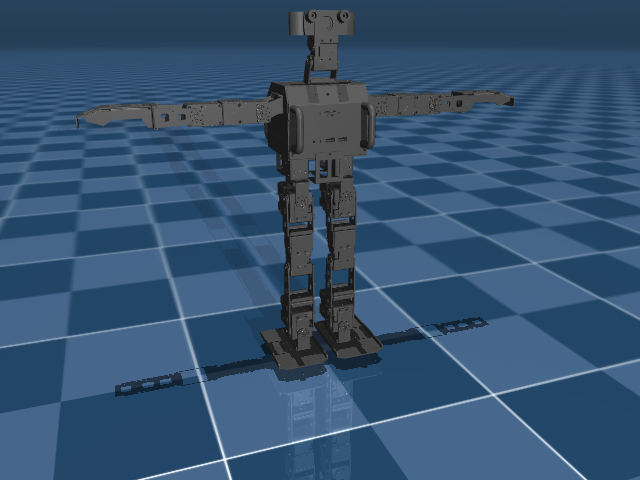

In [7]:
mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

## Checking for keyframes

In [8]:
for key in range(model.nkey):
  mujoco.mj_resetDataKeyframe(model, data, key)
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())

## Render!

In [9]:
np.random.seed(12345)

# Rendering options for visual and collision geoms.
# vis = mujoco.MjvOption()
# vis.geomgroup[2] = True
# vis.geomgroup[3] = False
coll = mujoco.MjvOption()
coll.geomgroup[2] = False
coll.geomgroup[3] = True
coll.flags[mujoco.mjtVisFlag.mjVIS_CONVEXHULL] = True

# Create a camera that will revolve around the robot.
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 1.5
offset = model.vis.global_.azimuth

# Sample actuator noise and smooth it.
nsteps = int(np.ceil(duration / model.opt.timestep))
perturb = np.random.randn(nsteps, model.nu)
width = int(nsteps * ctrl_rate / duration)
kernel = np.exp(-0.5 * np.linspace(-3, 3, width) ** 2)
kernel /= np.linalg.norm(kernel)
for i in range(model.nu):
  perturb[:, i] = np.convolve(perturb[:, i], kernel, mode="same")

# Set the desired control point.
if model.nkey > 0:
  mujoco.mj_resetDataKeyframe(model, data, 0)
  ctrl0 = data.ctrl.copy()
else:
  mujoco.mj_resetData(model, data)
  ctrl0 = np.mean(model.actuator_ctrlrange, axis=1)

frames = []
for i in tqdm(range(nsteps)):
  data.ctrl[:] = ctrl0 + ctrl_std * perturb[i]
  mujoco.mj_step(model, data)
  if len(frames) < data.time * fps:
    camera.azimuth = azimuth(data.time, duration, total_rot, offset)
    # renderer.update_scene(data, camera, scene_option=vis)
    # vispix = renderer.render().copy().astype(np.float32)
    renderer.update_scene(data, camera, scene_option=coll)
    collpix = renderer.render().copy().astype(np.float32)
    # b = blend_coef(data.time, duration, blend_std)
    # frame = (1 - b) * vispix + b * collpix
    frame = collpix
    frame = frame.astype(np.uint8)
    frames.append(frame)
media.show_video(frames, fps=fps, loop=False)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:14<00:00, 338.74it/s]
